In [1]:
from utils.metrics_utils import *
from models import *
import pandas as pd 
import matplotlib.pyplot as plt
import logomaker as lm
import pandas as pd
import os
import papermill as pm

In [2]:
the_tf = 'Insv'

In [3]:
index_word = {0:"A",
       1:"C",
       2:"G",
       3:"T"}

def calculate_saliency(seq, true_label, model):
    seq = np.array([seq])
    seq = tf.Variable(seq, dtype=float)

    with tf.GradientTape() as tape:
        pred = model(seq, training=False)
        cce = tf.keras.losses.BinaryCrossentropy()
        loss = cce(true_label, pred[0])
        loss = tf. convert_to_tensor(loss)


    # backpropogate to find gradients
    gradients = tape.gradient(pred, seq)
    # positive or negative gradients are all region change "dramatically"
#     grad_abs = tf.math.abs(gradients)
    grad_abs = tf.math.maximum(gradients,0)

    # normalize gradients to range between 0 and 1
    grad_min, grad_max  = np.min(grad_abs), np.max(grad_abs)
    grad_norm = (grad_abs - grad_min) / (grad_max - grad_min + 1e-18)
#     grad_norm = grad_abs/grad_max

    saliency = grad_norm[0]

    return saliency

def draw_logo_saliency(idx, model, target_seq, target_label,start, end):
    sal = calculate_saliency(target_seq[idx], target_label[idx], model)
    seq_saliency = sal[start:end][:,:4]
    oh_seq = target_seq[idx][:,:4]
    dnase = target_seq[idx][:, 4:]
    ori_seq = []
    for i in oh_seq:
        index, = np.where(i==1)
        if len(index) > 0:
            ori_seq.append(index_word[int(index)])
        else:
            # if the nt is N, we append A to replace
            ori_seq.append(index_word[0])
    original_sequence = ori_seq[start:end]
    dnase_saliency = sal[start:end][:,:4]
    true_label = target_label[idx][start:end]

    saliency_df = pd.DataFrame(np.array(seq_saliency))
    saliency_df = saliency_df.rename(columns=index_word)
    logo = lm.Logo(saliency_df, font_name='Hobo Std', figsize=(16,4))
    plt.xticks(np.arange(len(original_sequence)), list(original_sequence))
#     plt.plot(np.arange(len(dnase_saliency)), dnase_saliency, color='grey', marker='o',linewidth=2)
    plt.plot(np.arange(len(true_label[:])),true_label[:, -1], color='Red', alpha=0.5,linewidth=2, label=the_tf+" true label")
    plt.title("LOGO Saliency")
    plt.legend()

def return_logo_saliency(idx, model, target_seq, target_label,start, end):
    '''
    a naive function to return the 10nt saliency
    '''
    sal = calculate_saliency(target_seq[idx], target_label[idx], model)
    seq_saliency = sal[start:end][:,:4]
    seq = target_seq[idx][start:end][:,:4]

    return np.array(seq_saliency), np.array(seq)

In [4]:
logo_path="motif_logo_2.5/"+the_tf+"/"
if not os.path.isdir(logo_path):
        os.makedirs(logo_path, exist_ok=True)

integral_100_path = logo_path+"integral_top100/"
if not os.path.isdir(integral_100_path):
        os.makedirs(integral_100_path, exist_ok=True)

integral_all_path = logo_path+"integral_all/"
if not os.path.isdir(integral_all_path):
        os.makedirs(integral_all_path, exist_ok=True)
        
single_logo_path = logo_path+"single_top100/"
if not os.path.isdir(single_logo_path):
        os.makedirs(single_logo_path, exist_ok=True)

In [5]:
path = "preprocessed_"+the_tf+"_2.5.fimo_labels_fimo_data"
train_dataset = tf.data.experimental.load("preprocessed_data/"+path+"/train_data")
val_dataset = tf.data.experimental.load("preprocessed_data/"+path+"/validation_data")
test_dataset = tf.data.experimental.load("preprocessed_data/"+path+"/test_data")

2022-09-29 15:15:31.143900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 15:15:31.680929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


In [6]:
batch_size = 100
train_dataset = train_dataset.shuffle(2000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [7]:
model_path = "output/"+the_tf+"_2.5.fimo_labels_trans_unet_output/model/"
model = tf.keras.models.load_model(model_path, custom_objects={'dice_coef':dice_coef, 'f1_metrics':f1_metrics,'matthews_correlation_coefficient':matthews_correlation_coefficient})

In [8]:
model.evaluate(test_dataset)

2022-09-29 15:15:44.950383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


34/34 [==============================] - 10s 175ms/step - loss: 0.0015 - auc: 0.9718 - pr_auc: 0.7364 - f1_metrics: 0.6764 - dice_coef: 0.6193 - matthews_correlation_coefficient: 0.6799 - binary_io_u: 0.5229


[0.0015255386242642999,
 0.9717796444892883,
 0.7364358901977539,
 0.6763997673988342,
 0.6193059086799622,
 0.6798579096794128,
 0.5229207873344421]

In [9]:
pred_labels = model.predict(test_dataset)
pred_labels.shape

(3395, 2000, 1)

In [10]:
dataset = test_dataset.unbatch().enumerate()
true_input = []
true_labels = []
for element in dataset.as_numpy_iterator():
    true_input.append(element[1][0])
    true_labels.append(element[1][1])
    
true_labels = np.array(true_labels)
true_labels.shape

(3395, 2000, 1)

In [11]:
tf_pred = np.round(pred_labels[:,:,-1])
tf_true = np.round(true_labels[:,:,-1])

In [12]:
color_scheme = {
    'A' : [185/256, 36/256, 42/256],
    'C' : [50/256, 61/256, 132/256],
    'G' : [241/256, 172/256, 43/256],
    'T': [24/256,120/256,62/256]
}

### Motif Reconstruction Top100

In [13]:
tf_pred_sum = np.sum(tf_pred,axis=-1)
tf_pred_bind_idx = tf_pred_sum.nonzero()

tf_pred_bind_max = np.max(pred_labels[tf_pred_bind_idx[0],:,-1], axis=-1)
top_tf_pred_idx = tf_pred_bind_max.argsort()[-100:]

motif_shape = (10,4)
saliency_sum = np.zeros(motif_shape)
seq_sum = np.zeros(motif_shape)
c = 0
for idx in top_tf_pred_idx:
    # only reconstruct motif with high confidence prediction
    i = tf_pred_bind_idx[0][idx]
    if len(set(tf_pred[i]))>1 and np.max(pred_labels[i,:,-1])>0.9:
        # naive function just find the first binding site for each sequence
        value = np.where(tf_pred[i]==1)[0][0]
        tmp_sal,tmp_seq = return_logo_saliency(idx=i, model=model, 
                                   target_seq=true_input, target_label=true_labels,
                                   start=value-1, end=value+9)
        if tmp_sal.shape != motif_shape or tmp_seq.shape != motif_shape:
            print(tmp_sal.shape, tmp_seq.shape)
            continue
        saliency_sum += tmp_sal
        seq_sum += tmp_seq
        c+=1

findfont: Font family ['Hobo Std'] not found. Falling back to DejaVu Sans.


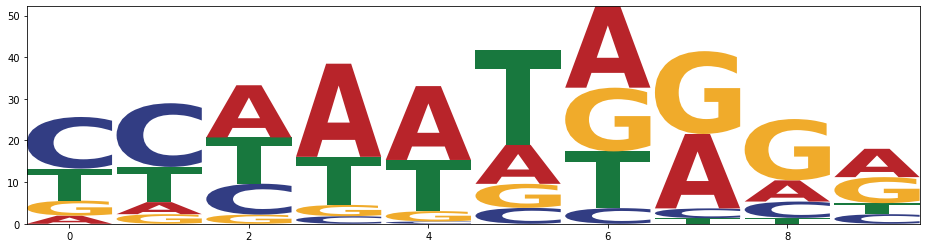

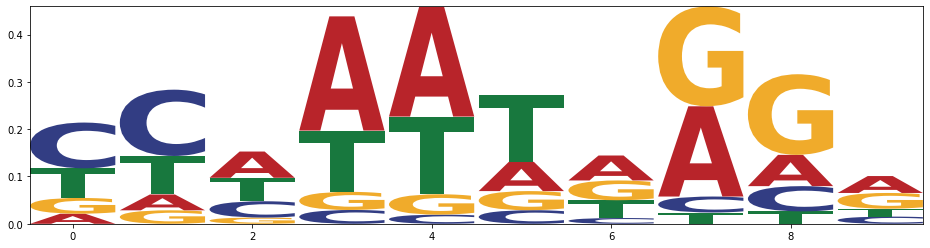

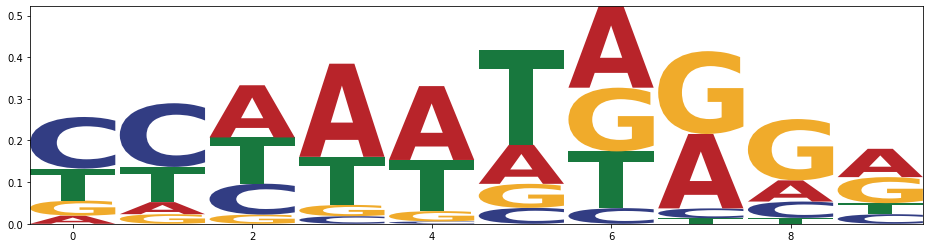

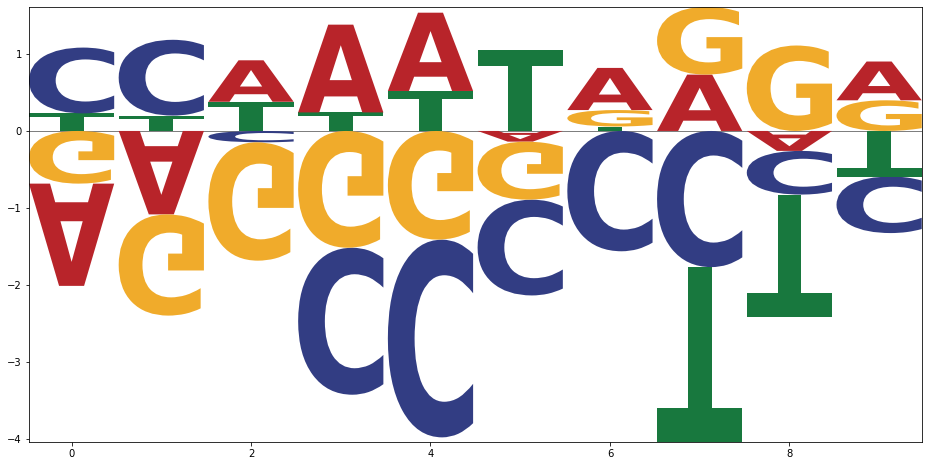

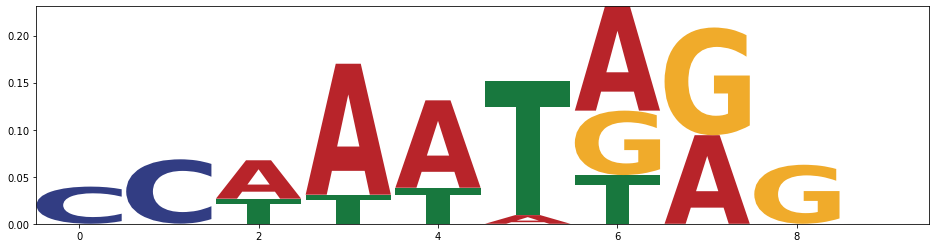

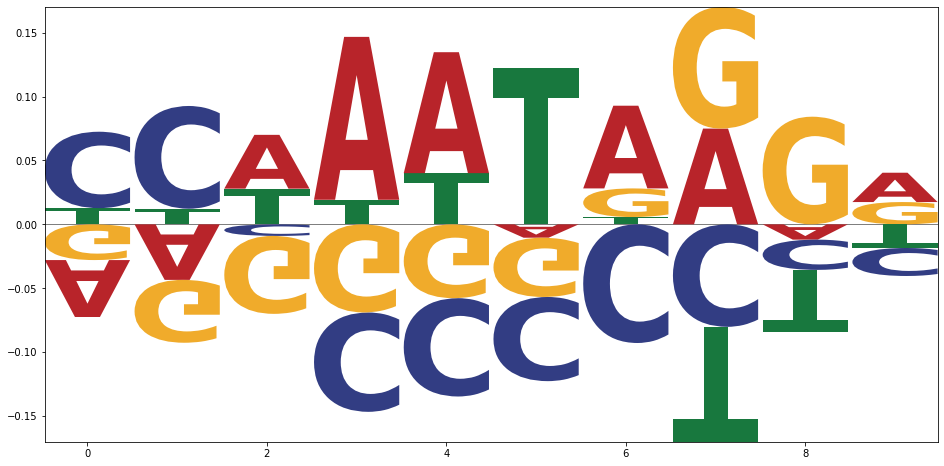

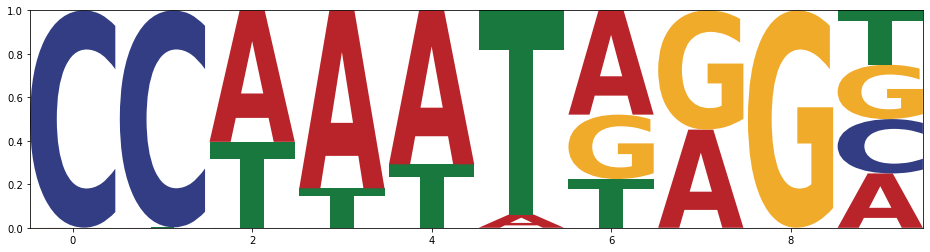

In [14]:
## 1. sum saliency
saliency_sum_df = pd.DataFrame(np.array(saliency_sum))
saliency_sum_df = saliency_sum_df.rename(columns=index_word)
saliency_sum_logo = lm.Logo(saliency_sum_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"saliency_sum_motif.svg", dpi=150)

## 2. count matrix to information matrix
saliency_info_df = lm.transform_matrix(saliency_sum_df,from_type='counts',to_type='information')
saliency_info_logo = lm.Logo(saliency_info_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"saliency_info_motif.svg", dpi=150)

## 3. average saliency
saliency_avg = saliency_sum/c
saliency_avg_df = pd.DataFrame(np.array(saliency_avg))
saliency_avg_df = saliency_avg_df.rename(columns=index_word)
lm.Logo(saliency_avg_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"saliency_avg_motif.svg", dpi=150)

## 4. saliency weight matrix, also refer to PWM
sal_weight_mat = lm.transform_matrix(saliency_sum_df, from_type='counts', to_type='weight')
lm.Logo(sal_weight_mat, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"saliency_weight_motif.svg", dpi=150)

## 5. remove background noise
denoise_saliency = saliency_avg-np.mean(saliency_avg)
denoise_saliency[denoise_saliency<0]=0.00001
denoise_saliency_df = pd.DataFrame(np.array(denoise_saliency))
denoise_saliency_df = denoise_saliency_df.rename(columns=index_word)
lm.Logo(denoise_saliency_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
plt.savefig(integral_100_path+"saliency_denoise_motif.svg", dpi=150)
plt.savefig(integral_100_path+"saliency_denoise_motif.pdf", dpi=150)

## 6. centered saliency
weight_mat_centered = lm.transform_matrix(saliency_avg_df, center_values=True)
lm.Logo(weight_mat_centered, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"saliency_centered_motif.svg", dpi=150)

## 7. normalized sequence
denoise_saliency_df = lm.validate_matrix(denoise_saliency_df, allow_nan=True)
weight_mat_normalized = lm.transform_matrix(denoise_saliency_df,normalize_values=True)
lm.Logo(weight_mat_normalized, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"normalized_saliency_motif.svg", dpi=150)

In [15]:
sal_df = []
sal_df.append(saliency_sum_df)
sal_df.append(saliency_info_df)
sal_df.append(saliency_avg_df)
sal_df.append(sal_weight_mat)
sal_df.append(denoise_saliency_df)
sal_df.append(weight_mat_centered)
sal_df.append(weight_mat_normalized)

### Sequence Motif Top100

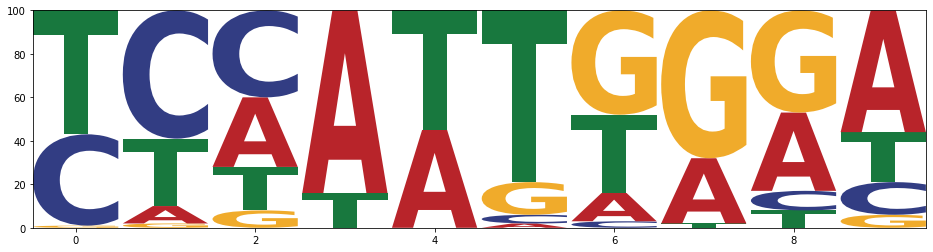

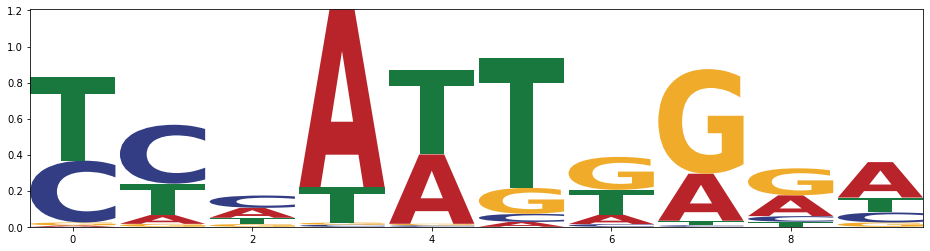

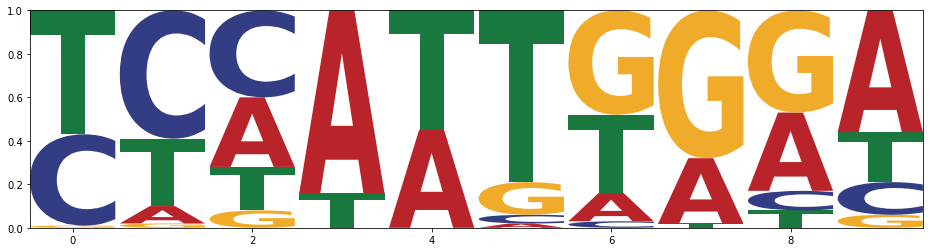

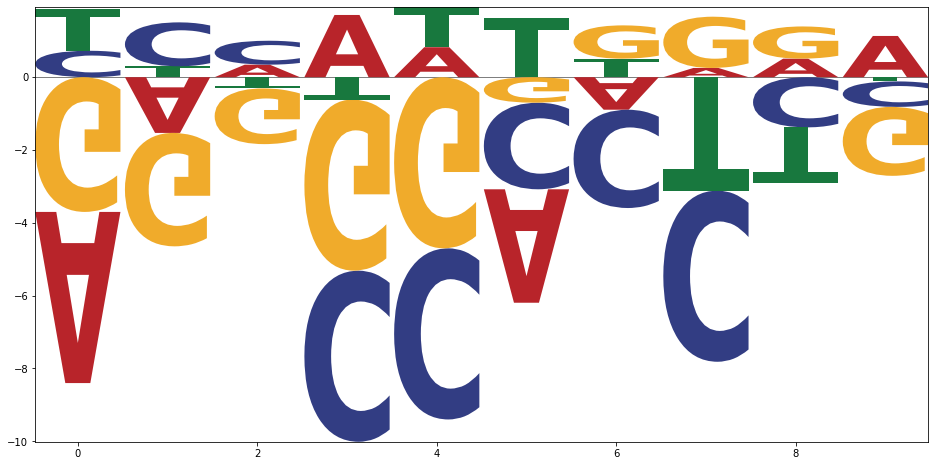

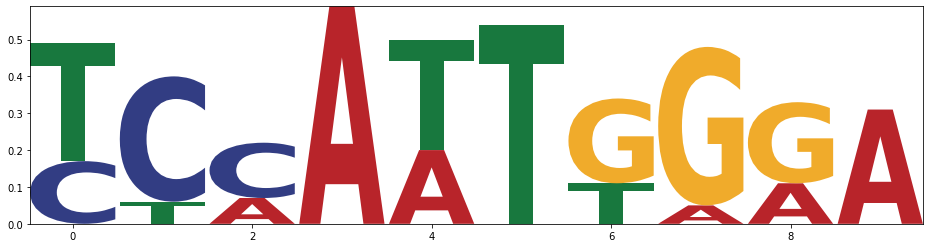

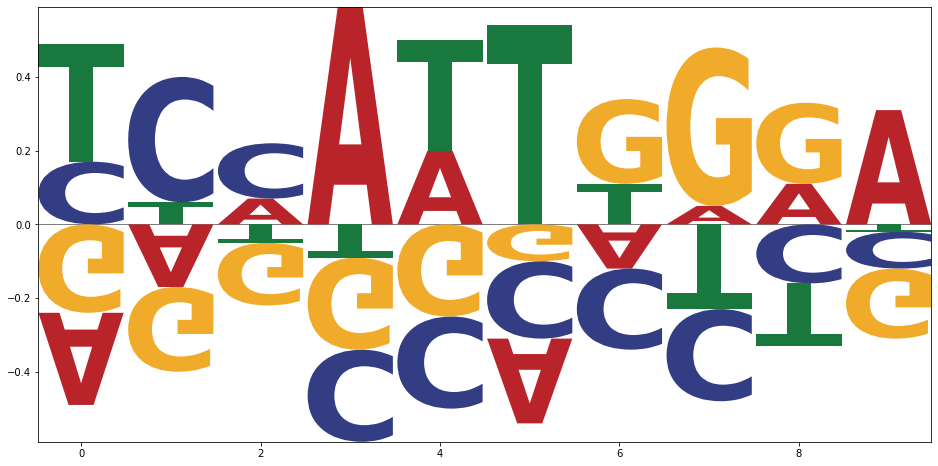

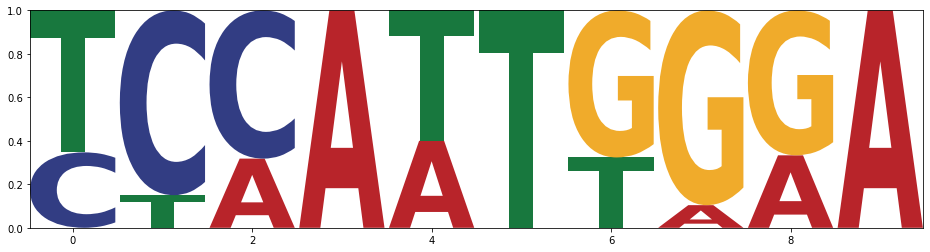

In [16]:
## 1. sum saliency
sequence_sum_df = pd.DataFrame(np.array(seq_sum))
sequence_sum_df = sequence_sum_df.rename(columns=index_word)
sequence_sum_logo = lm.Logo(sequence_sum_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"sequence_sum_motif.svg", dpi=150)

## 2. count matrix to information matrix
sequence_info_df = lm.transform_matrix(sequence_sum_df,from_type='counts',to_type='information')
sequence_info_logo = lm.Logo(sequence_info_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"sequence_info_motif.svg", dpi=150)

## 3. average sequence (propability)
sequence_avg = seq_sum/c
sequence_avg_df = pd.DataFrame(np.array(sequence_avg))
sequence_avg_df = sequence_avg_df.rename(columns=index_word)
sequence_avg_logo = lm.Logo(sequence_avg_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"sequence_avg_motif.svg", dpi=150)

## 4. sequence weight matrix, also refer to PWM
seq_weight_mat = lm.transform_matrix(sequence_sum_df, from_type='counts', to_type='weight')
lm.Logo(seq_weight_mat, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"sequence_weight_motif.svg", dpi=150)

## 5. remove background noise
denoise_sequence = sequence_avg-np.mean(sequence_avg)
denoise_sequence[denoise_sequence<0]=0
denoise_sequence_df = pd.DataFrame(np.array(denoise_sequence))
denoise_sequence_df = denoise_sequence_df.rename(columns=index_word)
lm.Logo(denoise_sequence_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
plt.savefig(integral_100_path+"denoise_sequence_motif.svg", dpi=150)
plt.savefig(integral_100_path+"denoise_sequence_motif.pdf", dpi=150)

## 6. centered sequence
weight_mat_centered = lm.transform_matrix(sequence_avg_df, center_values=True)
lm.Logo(weight_mat_centered, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"centered_sequence_motif.svg", dpi=150)

## 7. normalized sequence
weight_mat_normalized = lm.transform_matrix(denoise_sequence_df,normalize_values=True)
lm.Logo(weight_mat_normalized, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_100_path+"normalized_sequence_motif.svg", dpi=150)

In [17]:
seq_df = []
seq_df.append(sequence_sum_df)
seq_df.append(sequence_info_df)
seq_df.append(sequence_avg_df)
seq_df.append(seq_weight_mat)
seq_df.append(denoise_sequence_df)
seq_df.append(weight_mat_centered)
seq_df.append(weight_mat_normalized)

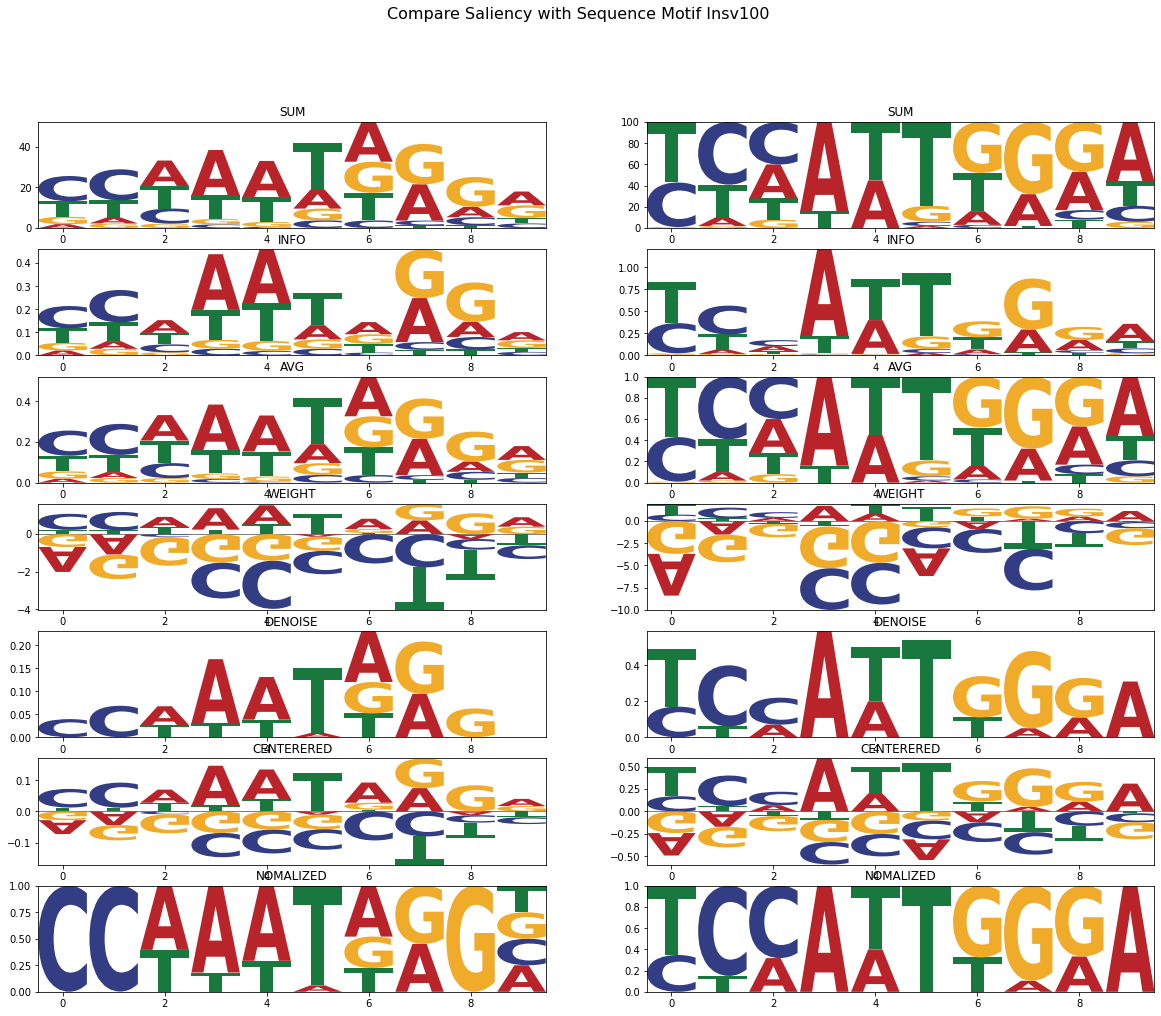

In [18]:
fig, axs = plt.subplots(7,2, figsize=(20,16))
title_df = ["SUM","INFO","AVG","WEIGHT","DENOISE","CENTERERED","NOMALIZED"]
fig.suptitle(f'Compare Saliency with Sequence Motif '+the_tf+str(c), fontsize=16)
for i in range(7):
    tmp_sal_df = sal_df[i]
    tmp_seq_df = seq_df[i]
    lm.Logo(tmp_sal_df, ax=axs[i][0],font_name='Hobo Std', color_scheme=color_scheme)
    axs[i][0].set_title(title_df[i])
    axs[i][1].set_title(title_df[i])
    lm.Logo(tmp_seq_df, ax=axs[i][1],font_name='Hobo Std', color_scheme=color_scheme)

plt.savefig(integral_100_path+"Summary Plot.svg", dpi=150)
plt.savefig(integral_100_path+"Summary Plot.pdf", dpi=150)

#### Motif Reconstruction Top 10 single motif

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

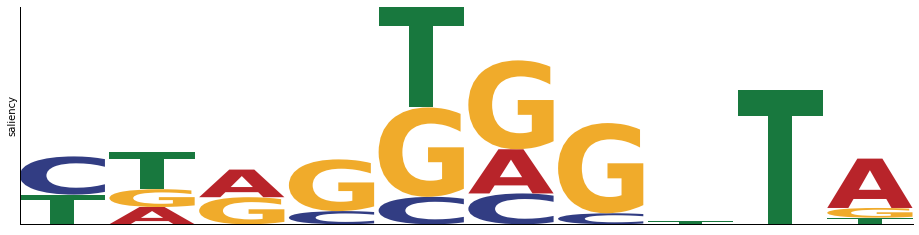

<Figure size 432x288 with 0 Axes>

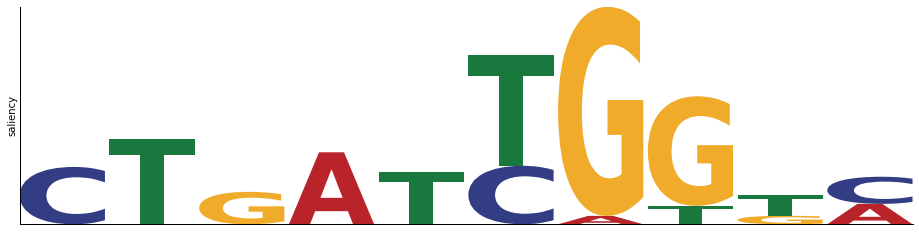

<Figure size 432x288 with 0 Axes>

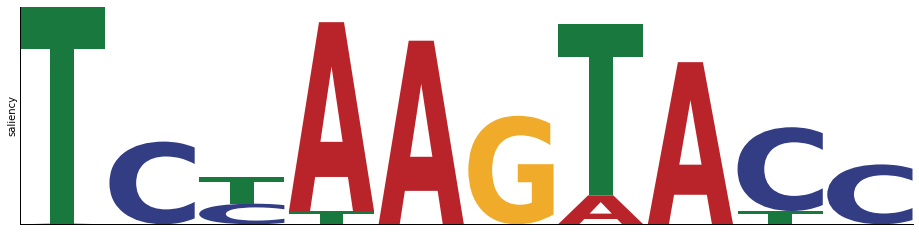

In [19]:
tf_pred_sum = np.sum(tf_pred,axis=-1)
tf_pred_bind_idx = tf_pred_sum.nonzero()

motif_shape = (10,4)
saliency_sum = np.zeros(motif_shape)
seq_sum = np.zeros(motif_shape)
c = 0
for ii, idx in enumerate(top_tf_pred_idx[-10:]):
    # only reconstruct motif with high confidence prediction
    i = tf_pred_bind_idx[0][idx]
    if len(set(tf_pred[i]))>1 and np.max(pred_labels[i,:,-1])>0.9:
        # naive function just find the first binding site for each sequence
        value = np.where(tf_pred[i]==1)[0][0]
        tmp_sal,tmp_seq = return_logo_saliency(idx=i, model=model, 
                                   target_seq=true_input, target_label=true_labels,
                                   start=value-1, end=value+9)
        if tmp_sal.shape != motif_shape or tmp_seq.shape != motif_shape:
            print(tmp_sal.shape, tmp_seq.shape)
            continue
        
        saliency_df = pd.DataFrame(np.array(tmp_sal))
        saliency_df = saliency_df.rename(columns=index_word)
        plt.figure(i)
        logo=lm.Logo(saliency_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
        logo.ax.set_ylabel('saliency', labelpad=-1)
        logo.ax.set_yticklabels([])
        logo.ax.set_xticklabels([])
        logo.ax.set_xticks([])
        logo.ax.set_yticks([])
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left'], visible=True)
        logo.style_spines(spines=['bottom'], visible=True)
        # plt.savefig(single_logo_path+f"denoise_motif_{idx}.svg", dpi=150)
        plt.savefig(single_logo_path+f"saliency_motif_{idx}.pdf", dpi=150)
        if ii > 6:
            plt.show()
        plt.close()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

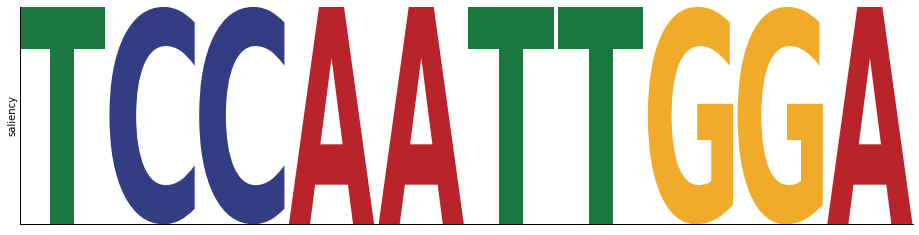

<Figure size 432x288 with 0 Axes>

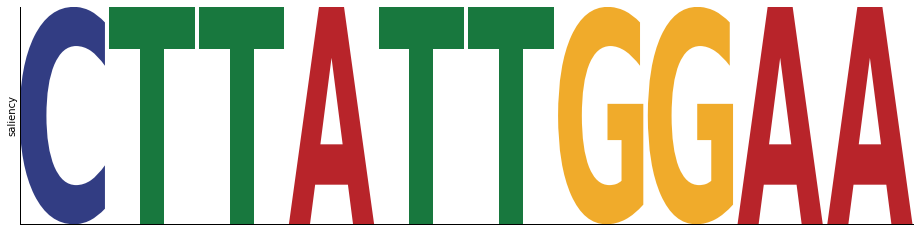

<Figure size 432x288 with 0 Axes>

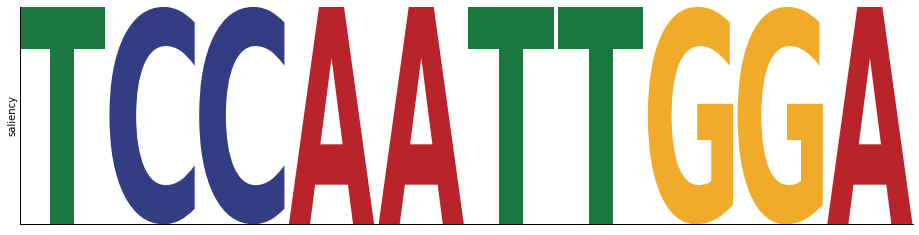

In [20]:
tf_pred_sum = np.sum(tf_pred,axis=-1)
tf_pred_bind_idx = tf_pred_sum.nonzero()

motif_shape = (10,4)
saliency_sum = np.zeros(motif_shape)
seq_sum = np.zeros(motif_shape)
c = 0
for ii, idx in enumerate(top_tf_pred_idx[-10:]):
    # only reconstruct motif with high confidence prediction
    i = tf_pred_bind_idx[0][idx]
    if len(set(tf_pred[i]))>1 and np.max(pred_labels[i,:,-1])>0.9:
        # naive function just find the first binding site for each sequence
        value = np.where(tf_pred[i]==1)[0][0]
        tmp_sal,tmp_seq = return_logo_saliency(idx=i, model=model, 
                                   target_seq=true_input, target_label=true_labels,
                                   start=value-1, end=value+9)
        if tmp_sal.shape != motif_shape or tmp_seq.shape != motif_shape:
            print(tmp_sal.shape, tmp_seq.shape)
            continue
        
        saliency_df = pd.DataFrame(np.array(tmp_seq))
        saliency_df = saliency_df.rename(columns=index_word)
        plt.figure(i)
        logo=lm.Logo(saliency_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
        logo.ax.set_ylabel('saliency', labelpad=-1)
        logo.ax.set_yticklabels([])
        logo.ax.set_xticklabels([])
        logo.ax.set_xticks([])
        logo.ax.set_yticks([])
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left'], visible=True)
        logo.style_spines(spines=['bottom'], visible=True)
        # plt.savefig(single_logo_path+f"denoise_motif_{idx}.svg", dpi=150)
        plt.savefig(single_logo_path+f"sequence_motif_{idx}.pdf", dpi=150)
        if ii > 6:
            plt.show()
        plt.close()

### Saliency Motif Reconstruction ALL

In [21]:
tf_pred_sum = np.sum(tf_pred,axis=-1)
tf_pred_bind_idx = tf_pred_sum.nonzero()

tf_pred_bind_max = np.max(pred_labels[tf_pred_bind_idx[0],:,-1], axis=-1)
top_tf_pred_idx = tf_pred_bind_max.argsort()

motif_shape = (10,4)
saliency_sum = np.zeros(motif_shape)
seq_sum = np.zeros(motif_shape)
c = 0
for idx in top_tf_pred_idx:
    # only reconstruct motif with high confidence prediction
    i = tf_pred_bind_idx[0][idx]
    if len(set(tf_pred[i]))>1 and np.max(pred_labels[i,:,-1])>0.9:
        # naive function just find the first binding site for each sequence
        value = np.where(tf_pred[i]==1)[0][0]
        tmp_sal,tmp_seq = return_logo_saliency(idx=i, model=model, 
                                   target_seq=true_input, target_label=true_labels,
                                   start=value-1, end=value+9)
        if tmp_sal.shape != motif_shape or tmp_seq.shape != motif_shape:
            print(tmp_sal.shape, tmp_seq.shape)
            continue
        saliency_sum += tmp_sal
        seq_sum += tmp_seq
        c+=1

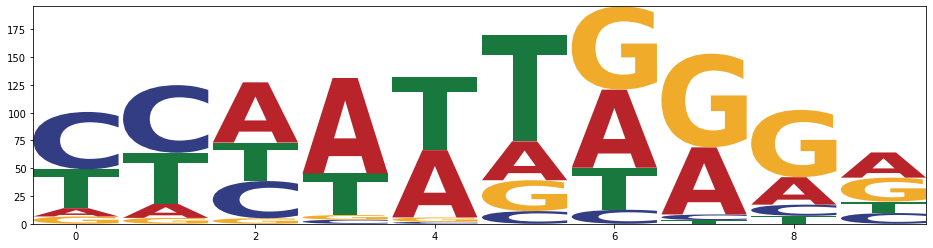

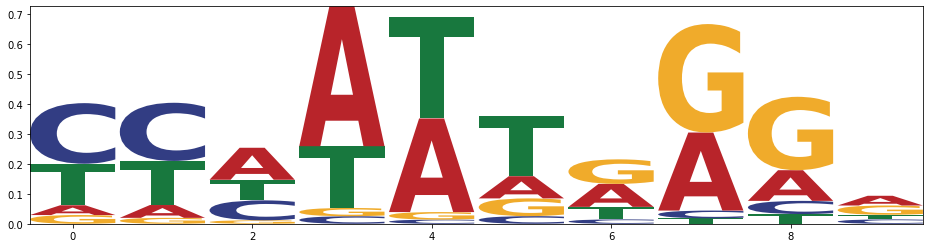

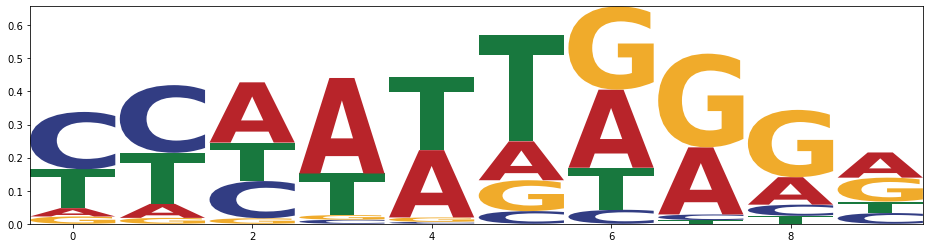

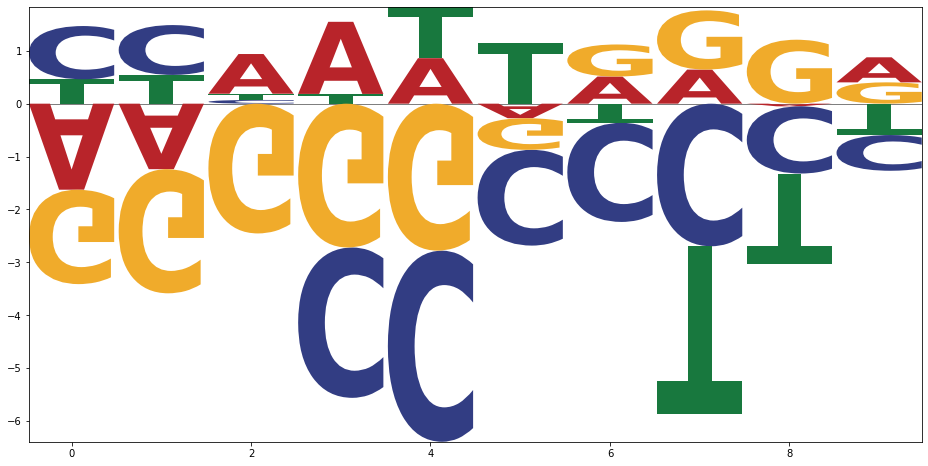

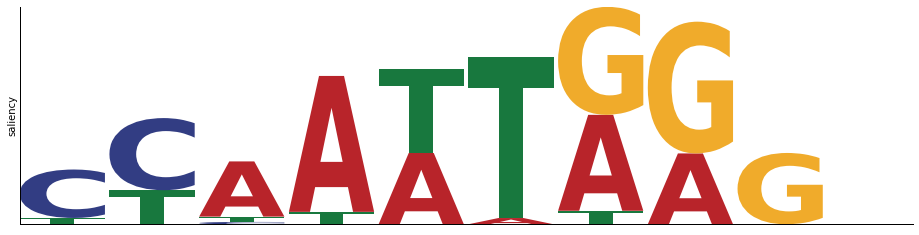

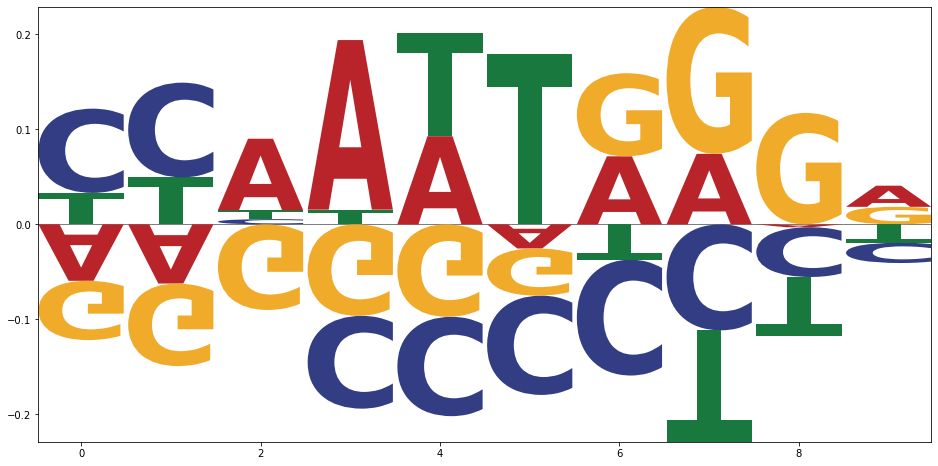

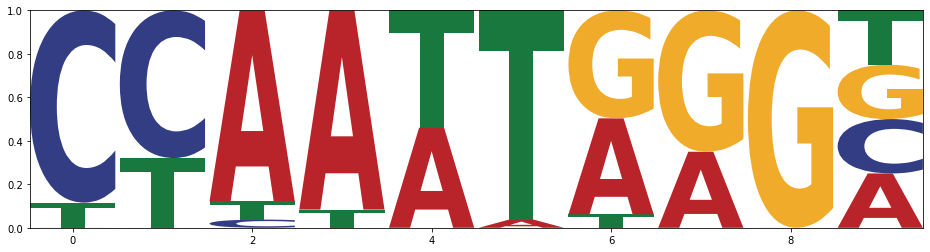

In [22]:
## 1. sum saliency
saliency_sum_df = pd.DataFrame(np.array(saliency_sum))
saliency_sum_df = saliency_sum_df.rename(columns=index_word)
saliency_sum_logo = lm.Logo(saliency_sum_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"saliency_sum_motif.svg", dpi=150)

## 2. count matrix to information matrix
saliency_info_df = lm.transform_matrix(saliency_sum_df,from_type='counts',to_type='information')
saliency_info_logo = lm.Logo(saliency_info_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"saliency_info_motif.svg", dpi=150)

## 3. average saliency
saliency_avg = saliency_sum/c
saliency_avg_df = pd.DataFrame(np.array(saliency_avg))
saliency_avg_df = saliency_avg_df.rename(columns=index_word)
lm.Logo(saliency_avg_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"saliency_avg_motif.svg", dpi=150)

## 4. saliency weight matrix, also refer to PWM
sal_weight_mat = lm.transform_matrix(saliency_sum_df, from_type='counts', to_type='weight')
lm.Logo(sal_weight_mat, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"saliency_weight_motif.svg", dpi=150)

## 5. remove background noise
denoise_saliency = saliency_avg-np.mean(saliency_avg)
denoise_saliency[denoise_saliency<0]=0.00001
denoise_saliency_df = pd.DataFrame(np.array(denoise_saliency))
denoise_saliency_df = denoise_saliency_df.rename(columns=index_word)
logo = lm.Logo(denoise_saliency_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
logo.ax.set_ylabel('saliency', labelpad=-1)
logo.ax.set_yticklabels([])
logo.ax.set_xticklabels([])
logo.ax.set_xticks([])
logo.ax.set_yticks([])
logo.style_spines(visible=False)
logo.style_spines(spines=['left'], visible=True)
logo.style_spines(spines=['bottom'], visible=True)
plt.savefig(integral_all_path+"saliency_denoise_motif.svg", dpi=150)
plt.savefig(integral_all_path+"saliency_denoise_motif.pdf", dpi=150)

## 6. centered saliency
weight_mat_centered = lm.transform_matrix(saliency_avg_df, center_values=True)
lm.Logo(weight_mat_centered, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"saliency_centered_motif.svg", dpi=150)

## 7. normalized sequence
denoise_saliency_df = lm.validate_matrix(denoise_saliency_df, allow_nan=True)
weight_mat_normalized = lm.transform_matrix(denoise_saliency_df,normalize_values=True)
lm.Logo(weight_mat_normalized, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"normalized_saliency_motif.svg", dpi=150)

In [23]:
sal_df = []
sal_df.append(saliency_sum_df)
sal_df.append(saliency_info_df)
sal_df.append(saliency_avg_df)
sal_df.append(sal_weight_mat)
sal_df.append(denoise_saliency_df)
sal_df.append(weight_mat_centered)
sal_df.append(weight_mat_normalized)

### Sequence Motif ALL

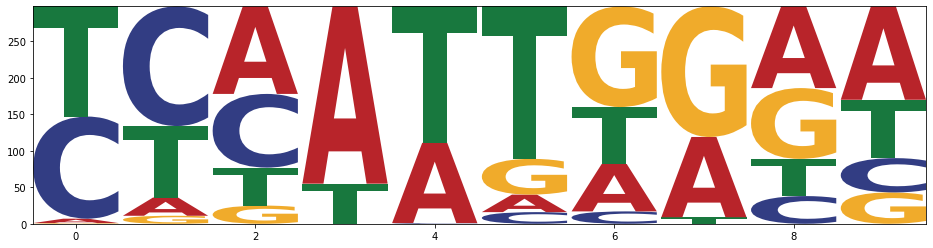

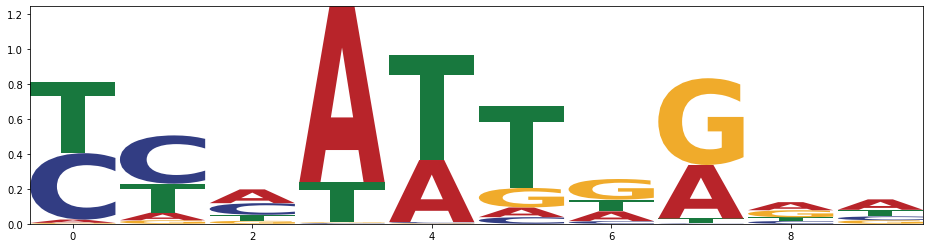

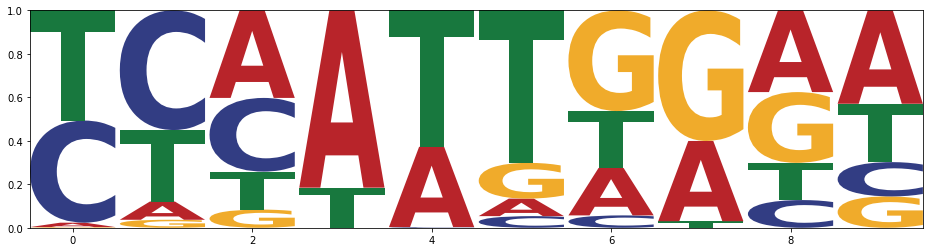

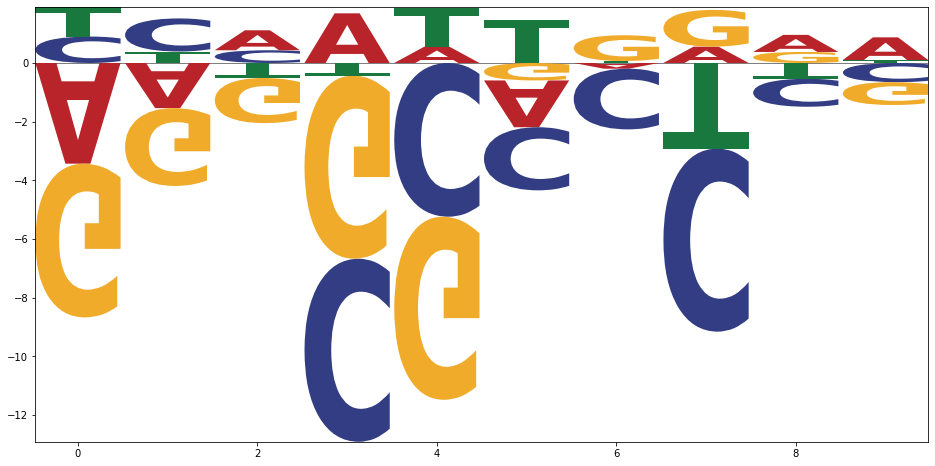

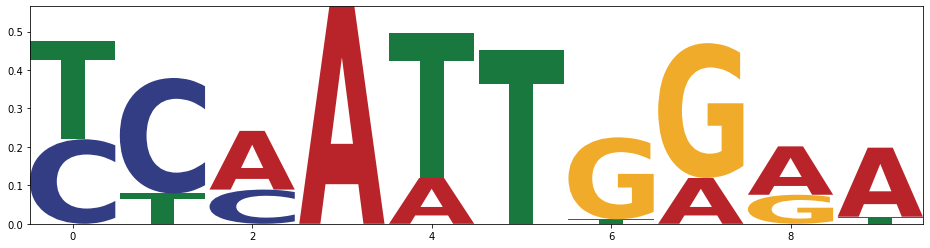

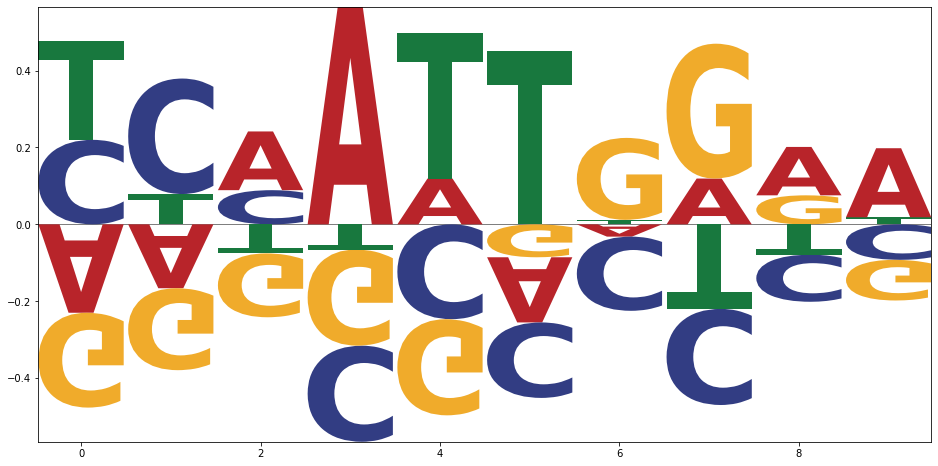

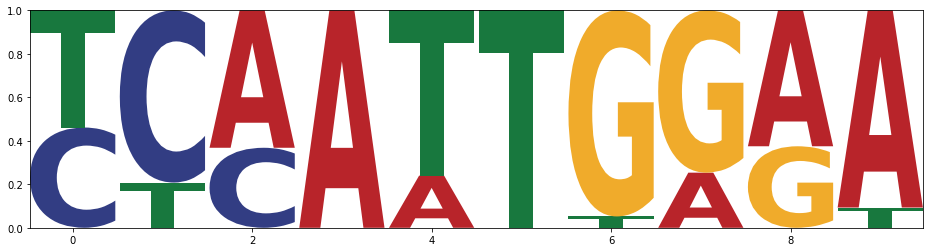

In [24]:
## 1. sum saliency
sequence_sum_df = pd.DataFrame(np.array(seq_sum))
sequence_sum_df = sequence_sum_df.rename(columns=index_word)
sequence_sum_logo = lm.Logo(sequence_sum_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"sequence_sum_motif.svg", dpi=150)

## 2. count matrix to information matrix
sequence_info_df = lm.transform_matrix(sequence_sum_df,from_type='counts',to_type='information')
sequence_info_logo = lm.Logo(sequence_info_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"sequence_info_motif.svg", dpi=150)

## 3. average sequence (propability)
sequence_avg = seq_sum/c
sequence_avg_df = pd.DataFrame(np.array(sequence_avg))
sequence_avg_df = sequence_avg_df.rename(columns=index_word)
sequence_avg_logo = lm.Logo(sequence_avg_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"sequence_avg_motif.svg", dpi=150)

## 4. sequence weight matrix, also refer to PWM
seq_weight_mat = lm.transform_matrix(sequence_sum_df, from_type='counts', to_type='weight')
lm.Logo(seq_weight_mat, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"sequence_weight_motif.svg", dpi=150)

## 5. remove background noise
denoise_sequence = sequence_avg-np.mean(sequence_avg)
denoise_sequence[denoise_sequence<0]=0
denoise_sequence_df = pd.DataFrame(np.array(denoise_sequence))
denoise_sequence_df = denoise_sequence_df.rename(columns=index_word)
lm.Logo(denoise_sequence_df, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
plt.savefig(integral_all_path+"denoise_sequence_motif.svg", dpi=150)
plt.savefig(integral_all_path+"denoise_sequence_motif.pdf", dpi=150)

## 6. centered sequence
weight_mat_centered = lm.transform_matrix(sequence_avg_df, center_values=True)
lm.Logo(weight_mat_centered, font_name='Hobo Std', figsize=(16,8), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"centered_sequence_motif.svg", dpi=150)

## 7. normalized sequence
weight_mat_normalized = lm.transform_matrix(denoise_sequence_df,normalize_values=True)
lm.Logo(weight_mat_normalized, font_name='Hobo Std', figsize=(16,4), color_scheme=color_scheme)
# plt.savefig(integral_all_path+"normalized_sequence_motif.svg", dpi=150)

In [25]:
seq_df = []
seq_df.append(sequence_sum_df)
seq_df.append(sequence_info_df)
seq_df.append(sequence_avg_df)
seq_df.append(seq_weight_mat)
seq_df.append(denoise_sequence_df)
seq_df.append(weight_mat_centered)
seq_df.append(weight_mat_normalized)

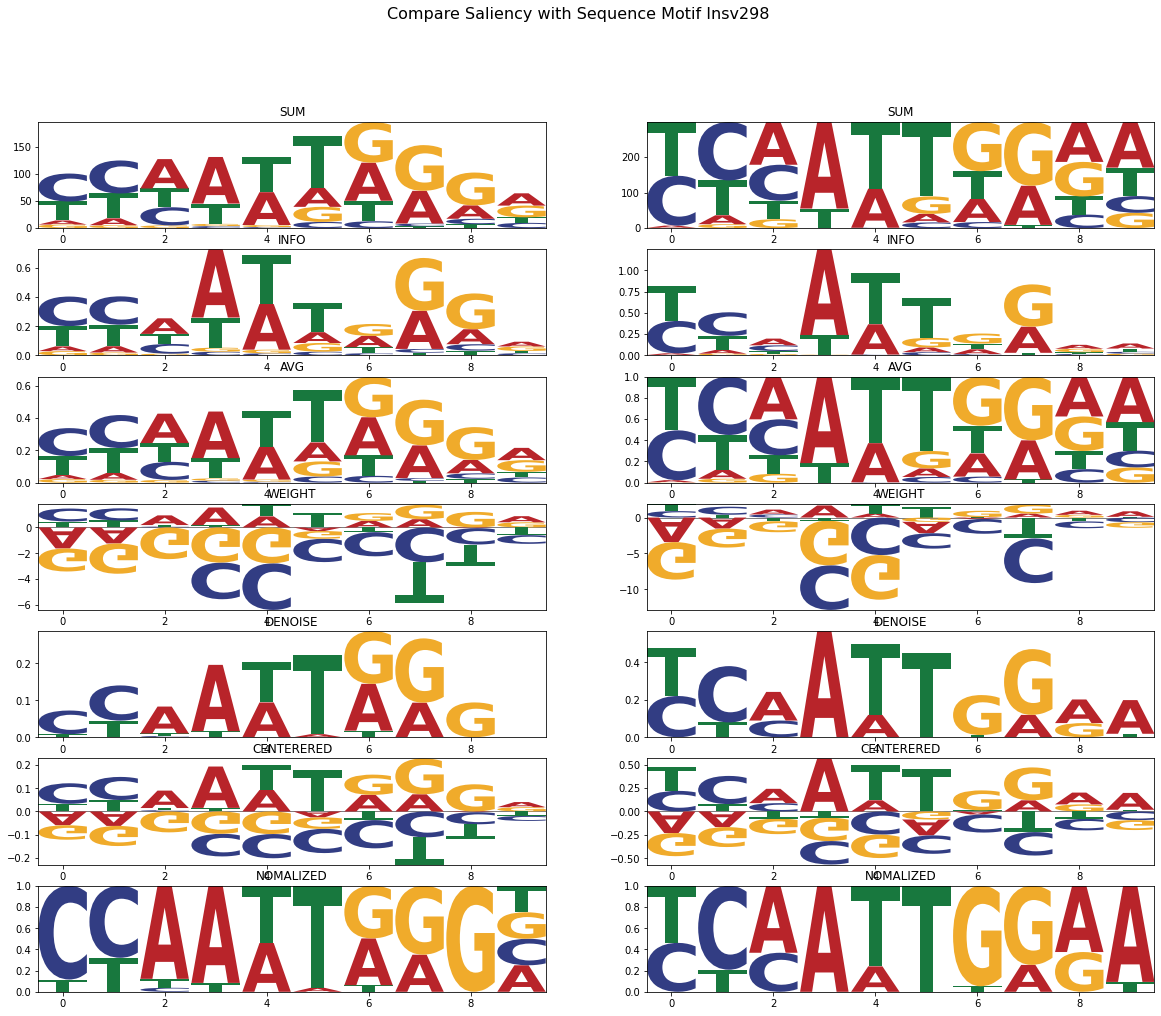

In [26]:
fig, axs = plt.subplots(7,2, figsize=(20,16))
title_df = ["SUM","INFO","AVG","WEIGHT","DENOISE","CENTERERED","NOMALIZED"]
fig.suptitle(f'Compare Saliency with Sequence Motif '+the_tf+str(c), fontsize=16)
for i in range(7):
    tmp_sal_df = sal_df[i]
    tmp_seq_df = seq_df[i]
    lm.Logo(tmp_sal_df, ax=axs[i][0],font_name='Hobo Std', color_scheme=color_scheme)
    axs[i][0].set_title(title_df[i])
    axs[i][1].set_title(title_df[i])
    lm.Logo(tmp_seq_df, ax=axs[i][1],font_name='Hobo Std', color_scheme=color_scheme)

plt.savefig(integral_all_path+"Summary Plot.svg", dpi=150)
plt.savefig(integral_all_path+"Summary Plot.pdf", dpi=150)